In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math
import re
import ast
from statsmodels.stats import diagnostic
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
import json

# Load Data

All data have been merged in Data_merge.ipynb and cleaned in cleaning_data.ipynb

In [5]:
data_path = './data/preprocessed_datasets/'
original_data = './data/original_datasets/'
#data_path = ''
data_character = pd.read_csv(data_path + 'clean_data_character.csv')
data_original = pd.read_csv(data_path + 'clean_data_original.csv')
ethnicity_df = pd.read_csv(data_path + 'ethnicity_labels.csv')
data_success = pd.read_csv(data_path + 'clean_data_success.csv')
tropes = pd.read_csv(original_data + 'CMU_dataset/tvtropes.clusters.txt', sep='\t', header=None, names=['trope', 'data'], engine='python')

# Extract the values inside the second set of quotes for each key-value pair
def extract_values(_str):
    return re.findall(r': "([^"]+)"', _str)

# Apply the extraction function to the relevant columns
data_success['Languages'] = data_success['Languages'].apply(extract_values)
data_success['Countries'] = data_success['Countries'].apply(extract_values)
data_success['Genres'] = data_success['Genres'].apply(extract_values)


# Representation of Male and Female Actors

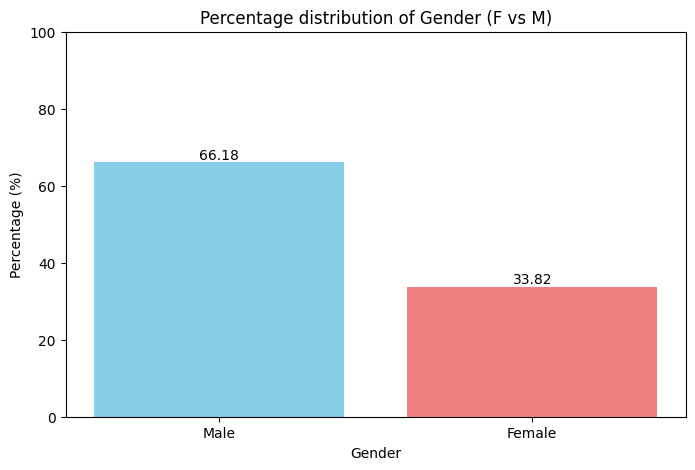

In [6]:
data_character_female = data_character[data_character["actor_gender"] == "F"]
data_character_male = data_character[data_character["actor_gender"] == "M"]
nbre_female = len(data_character_female)
nbre_male = len(data_character_male)
nbre_actors = nbre_male + nbre_female

gender_distrib= {
    'Gender': ['Male', 'Female'],
    'Percentage': [nbre_male*100/nbre_actors , nbre_female*100/nbre_actors]
}
df_gender_distrib = pd.DataFrame(gender_distrib)

plt.figure(figsize=(8, 5))
bars = plt.bar(df_gender_distrib ['Gender'], df_gender_distrib ['Percentage'], color=['skyblue', 'lightcoral'])

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height,                            
        f'{height:.2f}',                   
        ha='center',                       
        va='bottom'                         
    )

plt.title('Percentage distribution of Gender (F vs M)')
plt.xlabel('Gender')
plt.ylabel('Percentage (%)')
plt.ylim(0,100)
plt.xticks(rotation=0)
plt.show()

As expected, a significant difference is observed in the number of actors between men and women. Here, men represent 66.18% of the actors, while women account for 33.82%.  
Now, the question is: even if women have always been underrepresented in cinema since its inception, has their representation increased over the years?

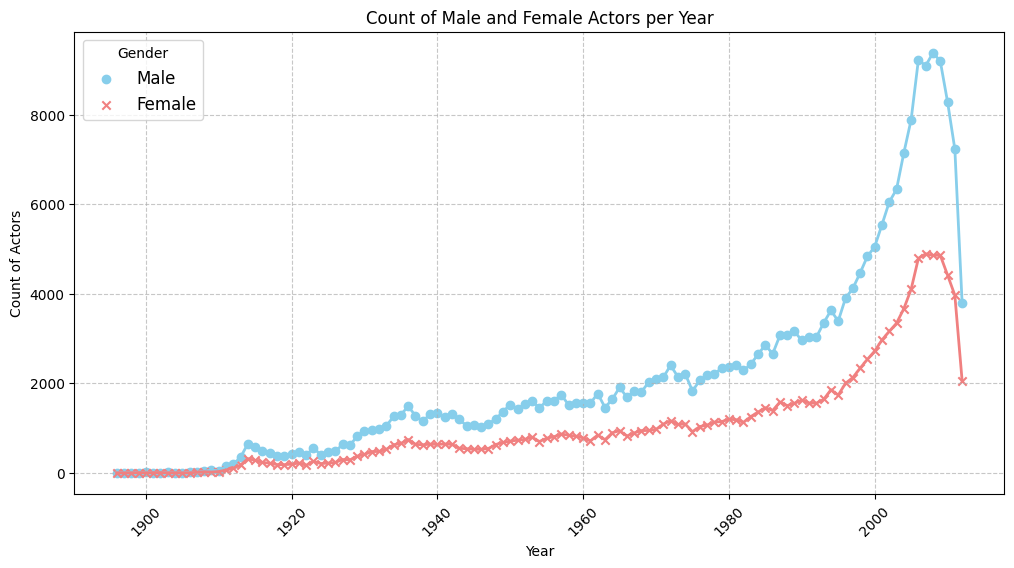

In [7]:
# Grouping data by release year and actor gender
gender_count_per_year = data_character.groupby(['release_year', 'actor_gender']).size().unstack(fill_value=0)

male_counts = gender_count_per_year['M']
female_counts = gender_count_per_year['F']
years = gender_count_per_year.index

plt.figure(figsize=(12, 6))

plt.plot(years, male_counts, color='skyblue', markersize=8, linestyle='-', linewidth=2)
plt.plot(years, female_counts, color='lightcoral', markersize=8, linestyle='-', linewidth=2)

plt.scatter(years, male_counts, color='skyblue', label='Male', marker='o')
plt.scatter(years, female_counts, color='lightcoral', label='Female', marker='x')

plt.title('Count of Male and Female Actors per Year')
plt.xlabel('Year')
plt.ylabel('Count of Actors')

plt.xticks(rotation=45)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(title='Gender', fontsize=12, loc='upper left', frameon=True)

plt.show()

After plotting the number of actors and actresses per year, it appears that their numbers have generally increased over the years for both, but a decline is observed after 2011. This is quite unusual, considering that the cinema industry itself has remained steady.


Upon investigation, we found that the decrease in the number of actors and actresses after 2011 is due to a decline in the number of movies in our dataset during that period. As a result, the number of actors naturally decreases, as shown in the plot below.

Given that the number of films per year is not consistent, to study the evolution of the number of actors over the years, it would be necessary to divide the number of actors by the number of films each year. This would make the data comparable across years.

Now, the focus is to observe whether the ratio of women to men evolves over the years.

In [8]:
movies_per_year = data_character.groupby('release_year')['Wiki_ID'].nunique()
# Calculate the ratio of female actors to movies per year 
ratio_male_to_movie = male_counts / movies_per_year
ratio_female_to_movie = female_counts / movies_per_year

# Calculate the ratio female/male per year 
ratio_female_male = female_counts / male_counts
ratio_female_male[male_counts == 0] = 1

As previously observed, the distribution of movies across years is uneven, with some years having significantly fewer movies represented in the dataset. This imbalance can introduce bias when analyzing trends or making comparisons over time. To ensure a more accurate and fair analysis, we limit our focus to years with a minimum of 500 movies. By doing so, we reduce the impact of data sparsity in underrepresented years and provide a more reliable foundation for examining patterns and correlations.

Male Ratio - Pearson Correlation Coefficient: 0.8253, p-value: 2.5876780052741712e-30, intercept=-20.02
Female Ratio - Pearson Correlation Coefficient: 0.7381, p-value: 2.203536060677413e-21, intercept=-11.31


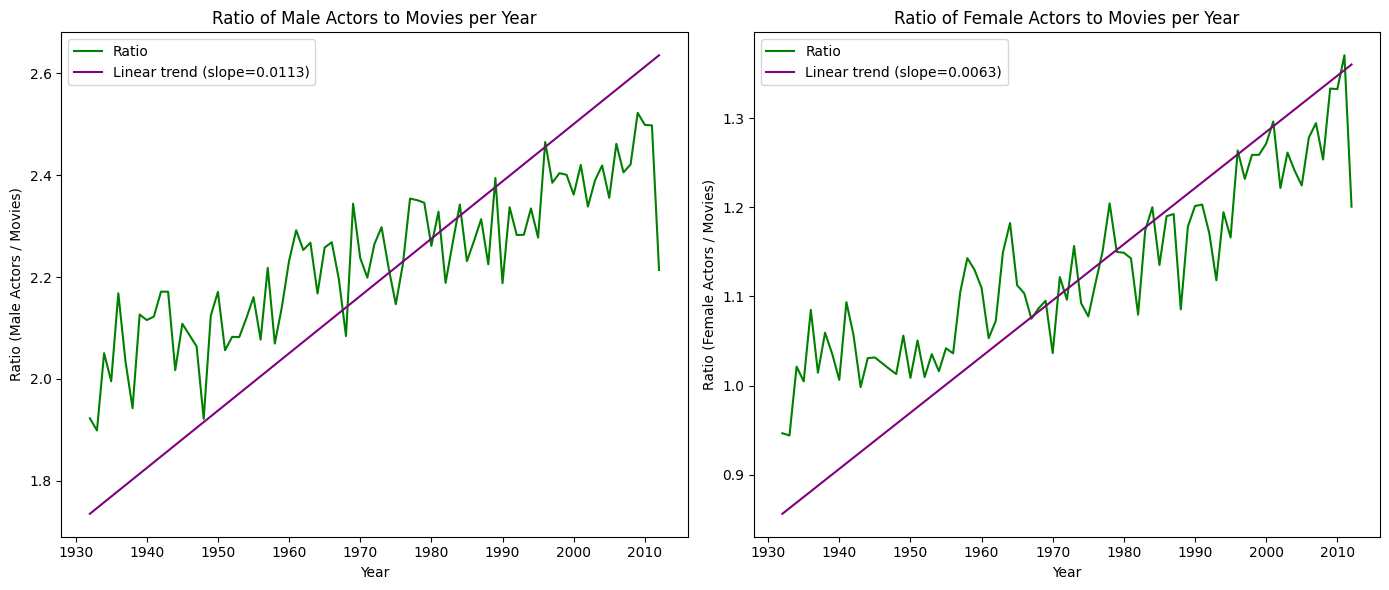

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

slope_male, intercept_male, rvalue_male, pvalue_male, stderr_male = stats.linregress(years, ratio_male_to_movie)

sns.lineplot(x=years[movies_per_year>500], y=ratio_male_to_movie[movies_per_year>500], label='Ratio', color= 'green', ax=axes[0])
axes[0].plot(years[movies_per_year>500], slope_male * years[movies_per_year>500] + intercept_male, color='purple', label=f'Linear trend (slope={slope_male:.4f})')
axes[0].legend()

axes[0].set_title('Ratio of Male Actors to Movies per Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Ratio (Male Actors / Movies)')

# Print statistics for Male to movie ratio
print(f"Male Ratio - Pearson Correlation Coefficient: {rvalue_male:.4f}, p-value: {pvalue_male}, intercept={intercept_male:.2f}")

# Female to movie ratio
slope_female, intercept_female, rvalue_female, pvalue_female, stderr_female = stats.linregress(years, ratio_female_to_movie)

sns.lineplot(x=years[movies_per_year>500], y=ratio_female_to_movie[movies_per_year>500], label='Ratio',color = 'green', ax=axes[1])
axes[1].plot(years[movies_per_year>500], slope_female * years[movies_per_year>500] + intercept_female, color='purple', label=f'Linear trend (slope={slope_female:.4f})')
axes[1].legend()

axes[1].set_title('Ratio of Female Actors to Movies per Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Ratio (Female Actors / Movies)')

# Print statistics for Female to movie ratio
print(f"Female Ratio - Pearson Correlation Coefficient: {rvalue_female:.4f}, p-value: {pvalue_female}, intercept={intercept_female:.2f}")

plt.tight_layout()
plt.show()

Analysis of the female-to-male ratio in movies over the years reveals that, while the ratio of women to men has remained largely unchanged over the decades, the absolute number of women in films has steadily increased. The linear regression of the ratio over time shows a slope of 0, indicating that the relative representation of women in films has not significantly shifted. However, a closer examination of the raw data reveals a consistent increase in the number of women appearing in movies each year. This suggests that while women's representation in relation to men remains stable, the overall participation of women in the film industry has grown over time.

Women remain underrepresented in cinema, a reality that has inspired various movements to promote gender equality in the industry. 

Another initiative is the Bechdel Test, introduced by Alison Bechdel in 1985. This simple yet powerful tool measures representation by requiring that a film include at least two women who talk to each other about something other than a man. While not comprehensive, the test highlights the widespread lack of meaningful roles for women and has become a key benchmark in discussions about gender equity in cinema.

There is, however, hope for change. Movements like Me Too and Time’s Up have raised awareness and advocated for greater inclusivity in storytelling and casting. Although the male-to-female ratio in the industry has not shifted dramatically, the absolute number of women working in cinema has grown, reflecting slow but steady progress.

Now, attention turns to the Bechdel Test to see if its analysis reveals a trend toward meaningful inclusion of women in film. By studying how movies have performed over time, we can assess whether representation is improving and whether these changes inspire optimism for the future of women in cinema.

## Tropes correlation

Rather then depicting the real-life women, cinema tends to perpetuate negative gender stereotypes which are reflected in the roles women play in films.
Some of our hypothesis is that women often receive secondary ad stereotypical representation tied to traditional roles of wives, lovers, mothers....
We think also that they are portrayed as overly emotional or dramatic.
We will also try to identify the tropes that leading to the greteast success.


In [10]:
characters = pd.read_csv(original_data + 'CMU_dataset/character_metadata.csv')
# Parse the JSON strings in the data column of the tropes dataset
tropes['data'] = tropes['data'].apply(ast.literal_eval)
# Normalize the 'data' dictionaries into separate columns
data_expanded = pd.json_normalize(tropes['data'])
# Combine the 'trope' column with the expanded data columns
tropes = pd.concat([tropes['trope'], data_expanded], axis=1)

FileNotFoundError: [Errno 2] No such file or directory: './data/preprocessed_datasets/character_metadata.csv'

**Data Enrichment**: Enrichment of the tropes dataset with additional characteristics from the characters dataset (e.g., gender, height, ethnicity, age at release,genre ...)

In [12]:
# Ensure the actor column is named consistently in both DataFrames
characters.rename(columns={'actor_name': 'actor'}, inplace=True)

# Create a dictionary mapping from actor to gender
gender_mapping = characters.set_index('actor')['actor_gender'].to_dict()
height_mapping = characters.set_index('actor')['actor_height'].to_dict()
ethnicity_mapping = characters.set_index('actor')['actor_ethnicity'].to_dict()
age_mapping = characters.set_index('actor')['actor_age_movie_released'].to_dict()

# Use the mapping to add the gender column in tropes based on the actor column
tropes['actor_gender'] = tropes['actor'].map(gender_mapping)
tropes['actor_height'] = tropes['actor'].map(height_mapping)
tropes['actor_ethnicity'] = tropes['actor'].map(ethnicity_mapping)
tropes['actor_age_movie_released'] = tropes['actor'].map(age_mapping)

# Check for the matching column between tropes['id'] and each ID column in characters
matching_column = None
for col in ['character/actor_ID', 'character_ID', 'Actor_ID']:
    if tropes['id'].isin(characters[col]).any():
        matching_column = col
        print(f"Matching column found: {col}")
        break

if matching_column:
    # Perform the merge and directly add the Movie_ID column to the existing tropes DataFrame
    tropes = tropes.merge(
        characters[['Movie_ID', matching_column]],
        left_on='id',
        right_on=matching_column,
        how='left'
    )

# Drop the extra column used for merging if you don’t need it anymore
tropes.drop(columns=[matching_column], inplace=True)

# Rename the Movie_ID column to movie_id in tropes if desired
tropes.rename(columns={'Movie_ID': 'movie_id'}, inplace=True)

# Merge ethnicity label into tropes based on actor_ethnicity and ethnicity_ID
tropes = pd.merge(tropes, ethnicity_df[['ethnicity_ID', 'ethnicity_label']], left_on='actor_ethnicity', right_on='ethnicity_ID', how='left')

# Drop the redundant ethnicity_ID column if it's no longer needed
tropes.drop(columns=['ethnicity_ID'], inplace=True)

# Merge genres into tropes DataFrame based on Movie_ID
tropes = pd.merge(tropes, data_success[['Movie_ID', 'Genres', 'SuccessMetric']], left_on='movie_id', right_on='Movie_ID', how='left')

# Drop redundant column if necessary
tropes.drop(columns=['Movie_ID'], inplace=True)


Matching column found: character/actor_ID


**Filter**: seperate female characters from mens

In [13]:
tropes_w = tropes.loc[tropes['actor_gender'] =='F']

In [14]:
tropes_m = tropes.loc[tropes['actor_gender'] =='M']

**Calculating descriptive statistics**

In [15]:
tropes_w['trope'].describe()

count              69
unique             21
top       dumb_blonde
freq               10
Name: trope, dtype: object

In [16]:
tropes_m['trope'].describe()

count                   431
unique                   65
top       crazy_jealous_guy
freq                     25
Name: trope, dtype: object

There is a higher variety of tropes for male characters (65 unique versus 21 for female characters), and while "dumb_blonde" is the most frequent trope for women, "crazy_jealous_guy" dominates the male tropes in terms of frequency. The women in this dataset is additionaly underepresented, but we will continue to further analyze the distribution of each trope and compare between women and men.

**Distribution of each trope for both women and men, to see which tropes are more frequently associeted with each gender**

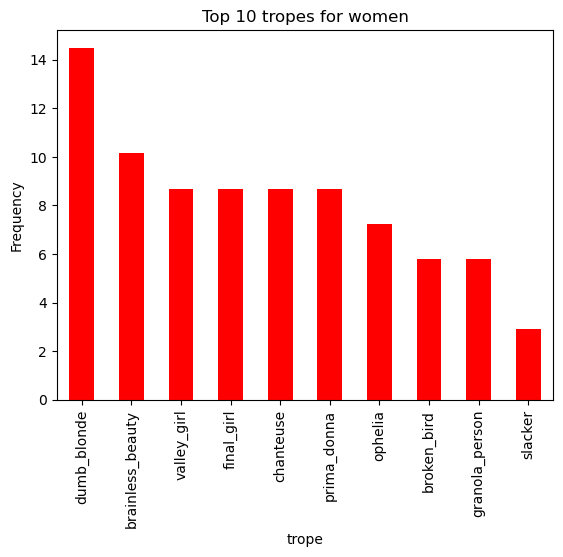

In [17]:
tropes_w_distribution = tropes_w['trope'].value_counts(normalize=True) * 100
tropes_m_distribution = tropes_m['trope'].value_counts(normalize=True) * 100
top_tropes_w = tropes_w_distribution.head(10)
top_tropes_m = tropes_m_distribution.head(10)

# Plotting the top 10 tropes for women and men
top_tropes_w.plot(kind='bar', title='Top 10 tropes for women', color='red')
plt.ylabel('Frequency')
plt.show()

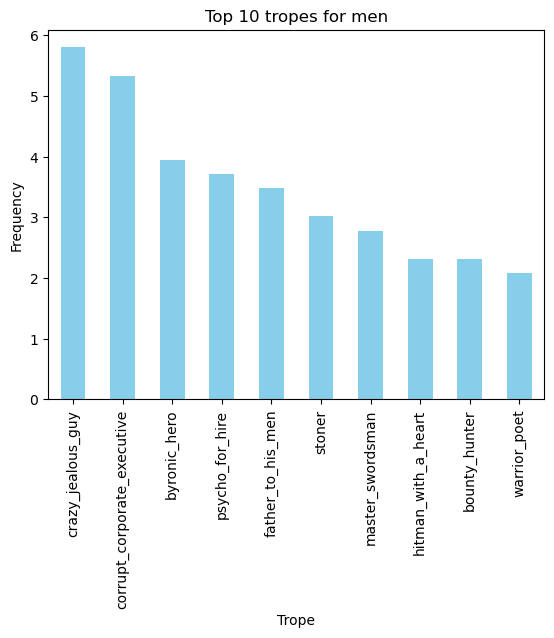

In [18]:
# Plot the top 10 tropes for men
top_tropes_m.plot(kind='bar', title = 'Top 10 tropes for men',color='skyblue')
plt.ylabel('Frequency')
plt.xlabel('Trope')
plt.show()

**Most frequent tropes in cinema for female characters**: As expected the cinema frequently relies on stereotypical portrayals that reinforce traditional gender biases. Tropes like "dumb_blonde," "brainless_beauty," "valley_girl," and "prima_donna" dominate, emphasizing superficial or appearance-focused qualities, which align with stereotypes that reduce women to their looks or perceived lack of intelligence.
Emotionally charged roles, such as "ophelia," "broken_bird," and "chanteuse," suggest that women are often portrayed as overly emotional, fragile, or in need of rescue, reinforcing the notion that women lack emotional stability or independence. Thus, female characters are more often defined by their personalities or relationships rather than ambition, skills, or leadership. 

**Chi-square test for gender and trope association**: Let's see if the gender and trope type are independent of each other.

In [19]:
# Create contingency table
contingency_table = pd.crosstab(tropes['actor_gender'], tropes['trope'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square Test:")
print("Chi2 Statistic:", chi2)
print("P-value:", p)

Chi-square Test:
Chi2 Statistic: 369.8513527525936
P-value: 5.592160386860096e-42


The Chi-square statistic of 370.63 indicates a strong deviation from the expected frequency distribution of the tropes between different genders. The very small p-value (close to 0) suggests that the result is statistically significant, meaning there is a highly significant association between the gender of the actor and the trope they portray. This means that the distribution of tropes across genders is not due to random chance, but rather there is a clear relationship between the two variables.

## Correlation between women trope and the success of a movie

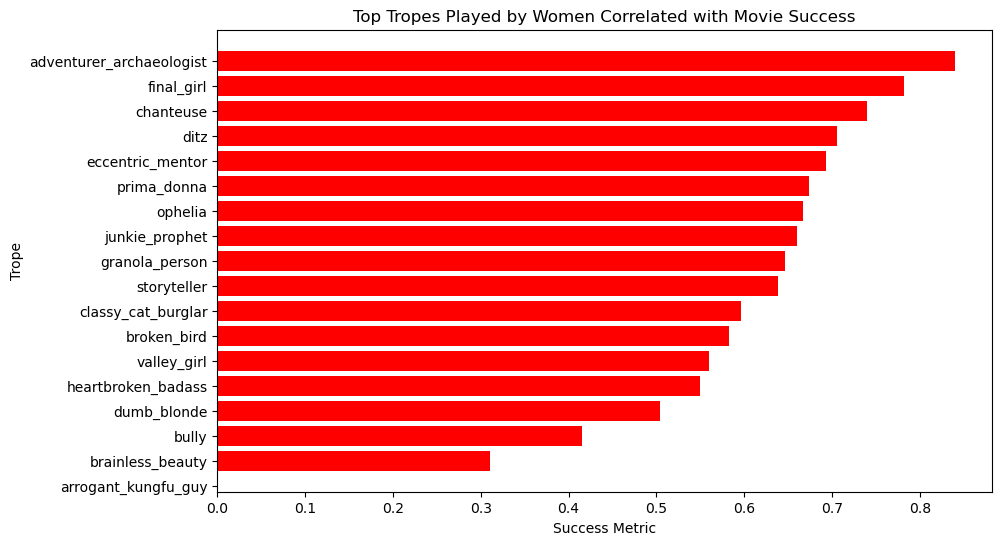

In [20]:
# Group by trope and calculate the average success for each trope
trope_success = tropes_w.groupby('trope')['SuccessMetric'].mean().reset_index()
# Calculate the correlation between each trope's success metric and movie success
correlation = trope_success['SuccessMetric'].corr(tropes_w['SuccessMetric'])

# Display tropes associated with high success
top_tropes = trope_success.sort_values(by='SuccessMetric', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(top_tropes['trope'], top_tropes['SuccessMetric'], color='red')
plt.xlabel('Success Metric')
plt.ylabel('Trope')
plt.title('Top Tropes Played by Women Correlated with Movie Success')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

### Regression analysis: Measure how much each trope contributes to the success metric, even when other factors are considered.
For example, an "adventurous" trope might perform better in action genres, or characters of certain ages or ethnic backgrounds might resonate more with audiences in particular tropes. By including these variables, regression helps us understand whether success depends on a combination of these factors.

**Is the relationship statistically significant?** A significant result suggests that the observed effect of a trope, genre and ethnicity on success is unlikely to be due to chance, giving us more confidence in our findings.

In [43]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Explode 'Genres' and drop rows missing required columns
tropes_w_exploded = tropes_w.explode('Genres')
tropes_w_exploded = tropes_w_exploded.dropna(subset=['SuccessMetric', 'actor_age_movie_released', 'ethnicity_label'])

# One-hot encode categorical variables
genre_encoded = pd.get_dummies(tropes_w_exploded['Genres'], prefix='Genre', dtype=bool)
trope_encoded = pd.get_dummies(tropes_w_exploded['trope'], prefix='Trope', dtype=bool)
ethnicity_encoded = pd.get_dummies(tropes_w_exploded['ethnicity_label'], prefix='Ethnicity', dtype=bool)

# Combine features
data_for_regression = pd.concat([
    tropes_w_exploded[['SuccessMetric', 'actor_age_movie_released']].reset_index(drop=True),
    genre_encoded.reset_index(drop=True),
    trope_encoded.reset_index(drop=True),
    ethnicity_encoded.reset_index(drop=True)
], axis=1)

# Convert all columns to numeric, coerce errors to NaN
data_for_regression = data_for_regression.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values
data_for_regression = data_for_regression.dropna()

# Define X (independent variables) and y (dependent variable)
X = data_for_regression.drop(columns=['SuccessMetric'])
y = data_for_regression['SuccessMetric']

# Convert boolean columns to float
X = X.astype(float)
y = y.astype(float)

# Add a constant to the DataFrame
X = sm.add_constant(X)

# Fit the OLS model using DataFrame X and Series y
model = sm.OLS(y, X).fit()

# Print the summary with the proper column names
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:          SuccessMetric   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     16.80
Date:                Sat, 14 Dec 2024   Prob (F-statistic):           2.48e-25
Time:                        14:39:25   Log-Likelihood:                 231.40
No. Observations:                 141   AIC:                            -318.8
Df Residuals:                      69   BIC:                            -106.5
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [44]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          SuccessMetric   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     16.80
Date:                Sat, 14 Dec 2024   Prob (F-statistic):           2.48e-25
Time:                        14:39:33   Log-Likelihood:                 231.40
No. Observations:                 141   AIC:                            -318.8
Df Residuals:                      69   BIC:                            -106.5
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

**R-squared:**  0.945, the model explains 96.5% of the variance in the SuccessMetric. This suggests that the predictors (genre, tropes, and ethnicity) together provide a strong explanation for movie success.

**Adjusted R-squared:** 0.889, this high value accounts for the number of predictors in the model, suggesting that even with many predictors, the model is robust.

**Durbin-Watson:** 0.873, which suggests possible positive autocorrelation in the residuals. Ideally, this should be closer to 2 for no autocorrelation.
Condition Number: 2.01e+18, which is very high, indicating potential multicollinearity. This suggests that some predictor variables may be highly correlated with each other.

**P-values and Significance:** The coefficients with a p-value less than 0.05 are statistically significant, suggesting a reliable effect on the SuccessMetric.

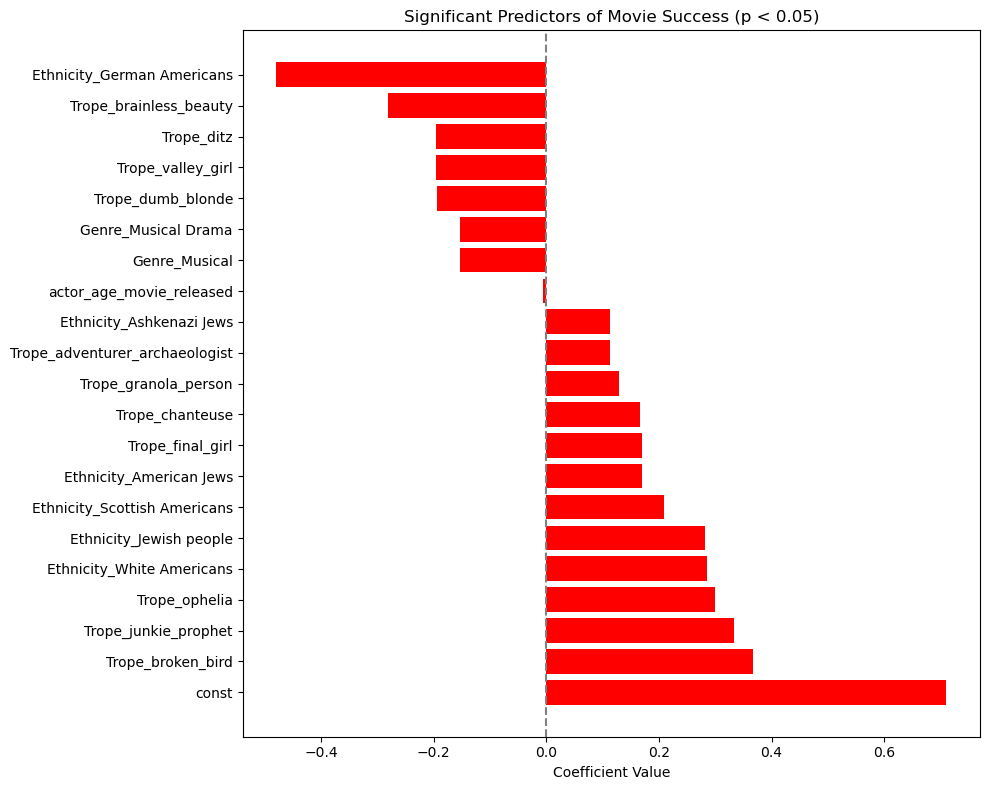

In [45]:
# Get the significant variables from the model summary
significant_vars = model.summary2().tables[1]
significant_vars = significant_vars[significant_vars['P>|t|'] < 0.05]

# Sort by the absolute value of the coefficients for better visualization
significant_vars = significant_vars.sort_values(by='Coef.', ascending=False)


plt.figure(figsize=(10, 8))
plt.barh(significant_vars.index, significant_vars['Coef.'], color='red')
plt.xlabel('Coefficient Value')
plt.title('Significant Predictors of Movie Success (p < 0.05)')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


Each bar in the plot corresponds to the coefficient for a specific variable (like Ethnicity_White Americans, Tope_dumb_blonde, etc.).
Positive coefficients push the SuccessMetric higher (more successful movie).
Negative coefficients suggest a negative relationship, meaning an increase in that variable could decrease the SuccessMetric.